## Time Series Forecasting

In [6]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "GOOG",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Close']]


In [7]:
df=df.astype(float)

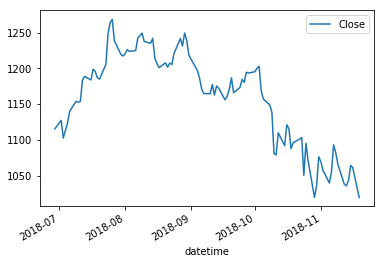

In [8]:
df.plot()

In [9]:
len(df)

100

In [10]:
# Sacar el RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

In [11]:
# obtener los valores del dataframe
X = df.values

# Dividir la data en train y test

train, test = X[0:-24], X[-24:]
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # make prediciton
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
#print('RMSE: %.3f' % RMSE)
print('RMSE {:.3f}'.format(rmse))


RMSE 26.137


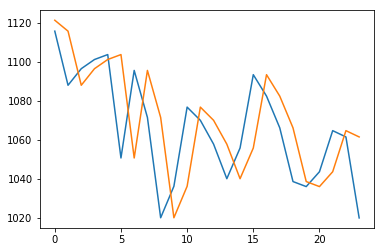

In [12]:
plt.plot(test)
plt.plot(predictions)

In [13]:
# Preparación de datos LSTM
def timeseries_to_supervised(data, lag=1):
    dataframe = pd.DataFrame(data)
    columns = [dataframe.shift(i) for i in range(1, lag+1)]
    columns.append(dataframe)
    dataframe = pd.concat(columns, axis=1)
    dataframe.fillna(0, inplace=True)
    
    return dataframe


supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

         0        0
0     0.00  1115.65
1  1115.65  1127.46
2  1127.46  1102.89
3  1102.89  1124.27
4  1124.27  1140.17


## Transformar series temporales a estacionarias

In [14]:
# crear series doferenciadas
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [22]:
# transform to be stationary
print(df.head())
differenced = difference(df.values, 1)
print( differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(X, differenced[i], len(X)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

              Close
datetime           
2018-06-29  1115.65
2018-07-02  1127.46
2018-07-03  1102.89
2018-07-05  1124.27
2018-07-06  1140.17
0     [11.809999999999945]
1    [-24.569999999999936]
2      [21.37999999999988]
3     [15.900000000000091]
4     [13.879999999999882]
dtype: object
0    [1127.46]
1    [1102.89]
2    [1124.27]
3    [1140.17]
4    [1154.05]
dtype: object


## Desarrollo de modelos LSTM

In [23]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
def forecast(model, batch_size, row):
    X = row[0:-1]
    X = X.reshape(1,1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]